In [6]:
from sklearn import svm, metrics
import glob, os.path, re, json
# 텍스트를 읽어 들이고 출현 빈도 조사하기 --- (※1)
def check_freq(fname):
    name = os.path.basename(fname)
    lang = re.match(r'^[a-z]{2,}', name).group()
    with open(fname, "r", encoding="utf-8") as f:
        text = f.read()
    text = text.lower() # 소문자 변환
    # 숫자 세기 변수(cnt) 초기화하기
    cnt = [0 for n in range(0, 26)]
    code_a = ord("a")
    code_z = ord("z")
    # 알파벳 출현 횟수 구하기 --- (※2)
    for ch in text:
        n = ord(ch)
        if code_a <= n <= code_z: # a~z 사이에 있을 때
            cnt[n - code_a] += 1
    # 정규화하기 --- (※3)
    total = sum(cnt)
    freq = list(map(lambda n: n / total, cnt))
    return (freq, lang)
    
# 각 파일 처리하기
def load_files(path):
    freqs = []
    labels = []
    file_list = glob.glob(path)
    for fname in file_list:
        r = check_freq(fname)
        freqs.append(r[0])
        labels.append(r[1])
    return {"freqs":freqs, "labels":labels}


#                                      <main_code>

data = load_files("./lang/train/*.txt")
test = load_files("./lang/test/*.txt")
# 이후를 대비해서 JSON으로 결과 저장하기
with open("./lang/freq.json", "w", encoding="utf-8") as fp:
    json.dump([data, test], fp)
# 학습하기 --- (※4)
clf.fit(data["freqs"], data["labels"])
# 예측하기 --- (※5)
predict = clf.predict(test["freqs"])
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(test["labels"], predict)
cl_report = metrics.classification_report(test["labels"], predict)
print("정답률 =", ac_score)
print("리포트 =")
print(cl_report)

정답률 = 0.875
리포트 =
              precision    recall  f1-score   support

          en       0.67      1.00      0.80         2
          fr       1.00      1.00      1.00         2
          id       1.00      0.50      0.67         2
          tl       1.00      1.00      1.00         2

    accuracy                           0.88         8
   macro avg       0.92      0.88      0.87         8
weighted avg       0.92      0.88      0.87         8



C:\Users\student\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


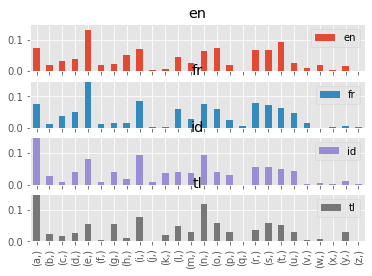

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import json
# 알파벳 출현 빈도 데이터 읽어 들이기 --- (※1)
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    freq = json.load(fp)
# 언어마다 계산하기 --- (※2)
lang_dic = {}
for i, lbl in enumerate(freq[0]["labels"]):
    fq = freq[0]["freqs"][i]
    if not (lbl in lang_dic):
        lang_dic[lbl] = fq
        continue
    for idx, v in enumerate(fq):
        lang_dic[lbl][idx] = (lang_dic[lbl][idx] + v) / 2
# Pandas의 DataFrame에 데이터 넣기 --- (※3)
asclist = [[chr(n) for n in range(97,97+26)]]
df = pd.DataFrame(lang_dic, index=asclist)
# 그래프 그리기 --- (※4)
plt.style.use('ggplot')
df.plot(kind="bar", subplots=True, ylim=(0,0.15))
plt.show()
#plt.savefig("lang-plot.png")

In [9]:
from sklearn import svm 
from sklearn.externals import joblib #joblib은 피클 라이브러리
import json
# 각 언어의 출현 빈도 데이터(JSON) 읽어 들이기
with open("./lang/freq.json", "r", encoding="utf-8") as fp:
    d = json.load(fp)
    data = d[0]
# 데이터 학습하기
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])
# 학습 데이터 저장하기
joblib.dump(clf, "./lang/freq.pkl")
print("ok")

ok


C:\Users\student\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\student\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
#!/usr/bin/env python3
import cgi, os.path
from sklearn.externals import joblib
# 학습 데이터 읽어 들이기
pklfile = os.path.dirname(__file__) + "/freq.pkl"
clf = joblib.load(pklfile)
# 텍스트 입력 양식 출력하기
def show_form(text, msg=""):
    print("Content-Type: text/html; charset=euc-kr")
    print("")
    print("""
        <html><body><form>
        <textarea name="text" rows="8" cols="40">{0}</textarea>
        <p><input type="submit" value="판정"></p>
        <p>{1}</p>
        </form></body></html>
    """.format(cgi.escape(text), msg))
# 판정하기
def detect_lang(text):
    # 알파벳 출현 빈도 구하기
    text = text.lower() 
    code_a, code_z = (ord("a"), ord("z"))
    cnt = [0 for i in range(26)]
    for ch in text:
        n = ord(ch) - code_a
        if 0 <= n < 26: cnt[n] += 1
    total = sum(cnt)
    if total == 0: return "입력이 없습니다"
    freq = list(map(lambda n: n/total, cnt))
    # 언어 예측하기
    res = clf.predict([freq])
    # 언어 코드를 한국어로 변환하기
    lang_dic = {"en":"영어","fr":"프랑스어",
        "id":"인도네시아어", "tl":"타갈로그어"}
    return lang_dic[res[0]]
# 입력 양식의 값 읽어 들이기
form = cgi.FieldStorage()
text = form.getvalue("text", default="")
msg = ""
if text != "":
    lang = detect_lang(text)
    msg = "판정 결과:" + lang
# 입력 양식 출력
show_form(text, msg)

In [2]:
from sklearn import svm, metrics
import glob, os.path, re, json

def check_freq(f_name):
    with open(f_name, "r", encoding='utf-8') as f:
        text = f.read()      #줄바꿈은 의미없다 그냥 그대로 읽어(음절분석)
    text = text.lower()
    
    count = [ 0 for n in range(0,26)]     #문서 하나당 알파벳 count 세기 위한 빈 리스트
    code_a = ord('a')          #아스키 코드값으로 전환 _ 리스트 인덱싱을 위해 
    code_z = ord('z')
    
    for ch in text:
        n = ord(ch)
        if code_a <= n <= code_z: # a~z 사이에 있을 때
            count[n - code_a] += 1
            
    #정규화 
    total = sum(count)
    freq = list(map(lambda n : n/total, count))
    
    name = os.path.basename(f_name)
    #print(name)
    lang = re.match(r'^[a-z]{2,}',name).group()  #정답지_label
    return freq, lang


def load_files(path):
    freqs = []
    labels = []
    file_list = glob.glob(path)
    for fname in file_list:
        r = check_freq(fname)
        print(r)
        freqs.append(r[0])
        labels.append(r[1])
    return {"freqs":freqs, "labels":labels}

data = load_files("./lang/train/*.txt")
test = load_files("./lang/test/*.txt")

with open("./lang/freq.json", "w", encoding="utf-8") as fp:
    json.dump([data, test], fp)
    
    
# 학습하기 --- (※4)
clf = svm.SVC()
clf.fit(data["freqs"], data["labels"])
# 예측하기 --- (※5)
predict = clf.predict(test["freqs"])
# 결과 테스트하기 --- (※6)
ac_score = metrics.accuracy_score(test["labels"], predict)
cl_report = metrics.classification_report(test["labels"], predict)
print("정답률 =", ac_score)
print("리포트 =")
print(cl_report)

([0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296], 'en')
([0.08417789436031954, 0.019911768212710148, 0.030404196971503518, 0.038869679265529984, 0.13699773458924527, 0.017407893167998092, 0.031238821986407535, 0.02742339334684631, 0.07535471563133421, 0.0026231071896983425, 0.009777035888875641, 0.042327411470132345, 0.024204125432216526, 0.05353523309884345, 0.06879694765708835, 0.020269464647669013, 0.005484678669369262, 0.09013950160963395, 0.07165851913675927, 0.07773935853105997, 0.0306426612

([0.16473616473616473, 0.026052026052026053, 0.014586014586014585, 0.04157404157404158, 0.08825708825708825, 0.006201006201006201, 0.035997035997036, 0.025116025116025117, 0.08205608205608206, 0.007254007254007254, 0.03853203853203853, 0.04301704301704302, 0.040872040872040875, 0.08985608985608985, 0.03116103116103116, 0.03634803634803635, 0.000156000156000156, 0.053625053625053626, 0.048789048789048786, 0.05323505323505324, 0.047424047424047426, 0.00468000468000468, 0.004602004602004602, 0.000468000468000468, 0.01482001482001482, 0.000585000585000585], 'id')
([0.1855536497045931, 0.019668381932532876, 0.01437011625690871, 0.0267200304936154, 0.03308557270821422, 0.007966457023060796, 0.08252334667429007, 0.014065180102915952, 0.08172288927005908, 0.00022870211549456832, 0.023861254049933295, 0.03552506194015628, 0.03815513626834382, 0.12224128073184677, 0.05812845435486945, 0.03129407280350677, 0.0001524680769963789, 0.03582999809414904, 0.05870020964360587, 0.05225843339050886, 0.023

C:\Users\student\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [34]:
os.getcwd()

'c:\\py_data\\언어판별프로그램'

In [35]:
os.path.dirname(os.path.abspath(__file__))

NameError: name '__file__' is not defined

In [36]:
os.path.abspath(__file__)

NameError: name '__file__' is not defined

In [37]:
location = os.path.split(os.path.abspath(__file__))[0]
print(location)

NameError: name '__file__' is not defined